# Classification - heart disease
> A notebook exploring a medical dataset to build a predicitive model to classify patients as having heart disease or not.

- toc: true 
- badges: false
- comments: true
- categories: [classification]
- image: images/classification.png
- author: Aidan Hood

## Summary
The aim of this project is to experiment with data manipulation, adequateley prepare a dataset for use and apply various classification models to the manipulated data in order to build an accurate classification model. I also employed hyperparameter tuning to the best model to further increase performance.

All in all, I developed a classification model with accuracy and F1 scores both around 0.83. The recall score, which is particulary important for medical classification models, sat at 0.91.




## Libraries

In [268]:
#collapse-hide
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings(action='ignore')
pd.set_option("max_columns", 25)

## Data input and exploration

Firstly, I read in the dataset and had a little explore of the features. This was a relativley small dataset of 303 entries, with 13 features contributing to the classification of either no heart disease (0) or heart disease (1). It was also good to see that the dataset was complete, with no null values across all entries, so there was no need for dealing with any null values.

In [2]:
df = pd.read_csv("./heart.csv")

In [5]:

print(df.head)

print(df.info())


<bound method NDFrame.head of      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1      

Next, I wanted to visualise the distribution of the features. As you can see, there are a significant number of categorical features, which I will deal with later. For completeness, see below for the full desscription of the features:

- age: Self explanatory
- sex: 0 is female, 1 is male
- cp: Chest pain type in increasing severity
- trestbps: Resting blood pressure upon hospital admission
- chol: Cholestoral levels
- fbs: Was the patient fasting (1 = true, 0 = false)
- restecg: Category of resting electrocardiograph results
- thalach: Maximum heart rate
- exang: Does the patient suffer from exercise induced angina (1 = true, 0 = false)
- oldpeak: ST depression induced by exercise
- slope: The slope of the peak exercise ST segment
- ca: Number of major vessels (0-3) colored by fluoroscopy
- thal: Category of a blood disorder called thalassemia 
- target: Heart disease or not (1 = true, 0 = false)


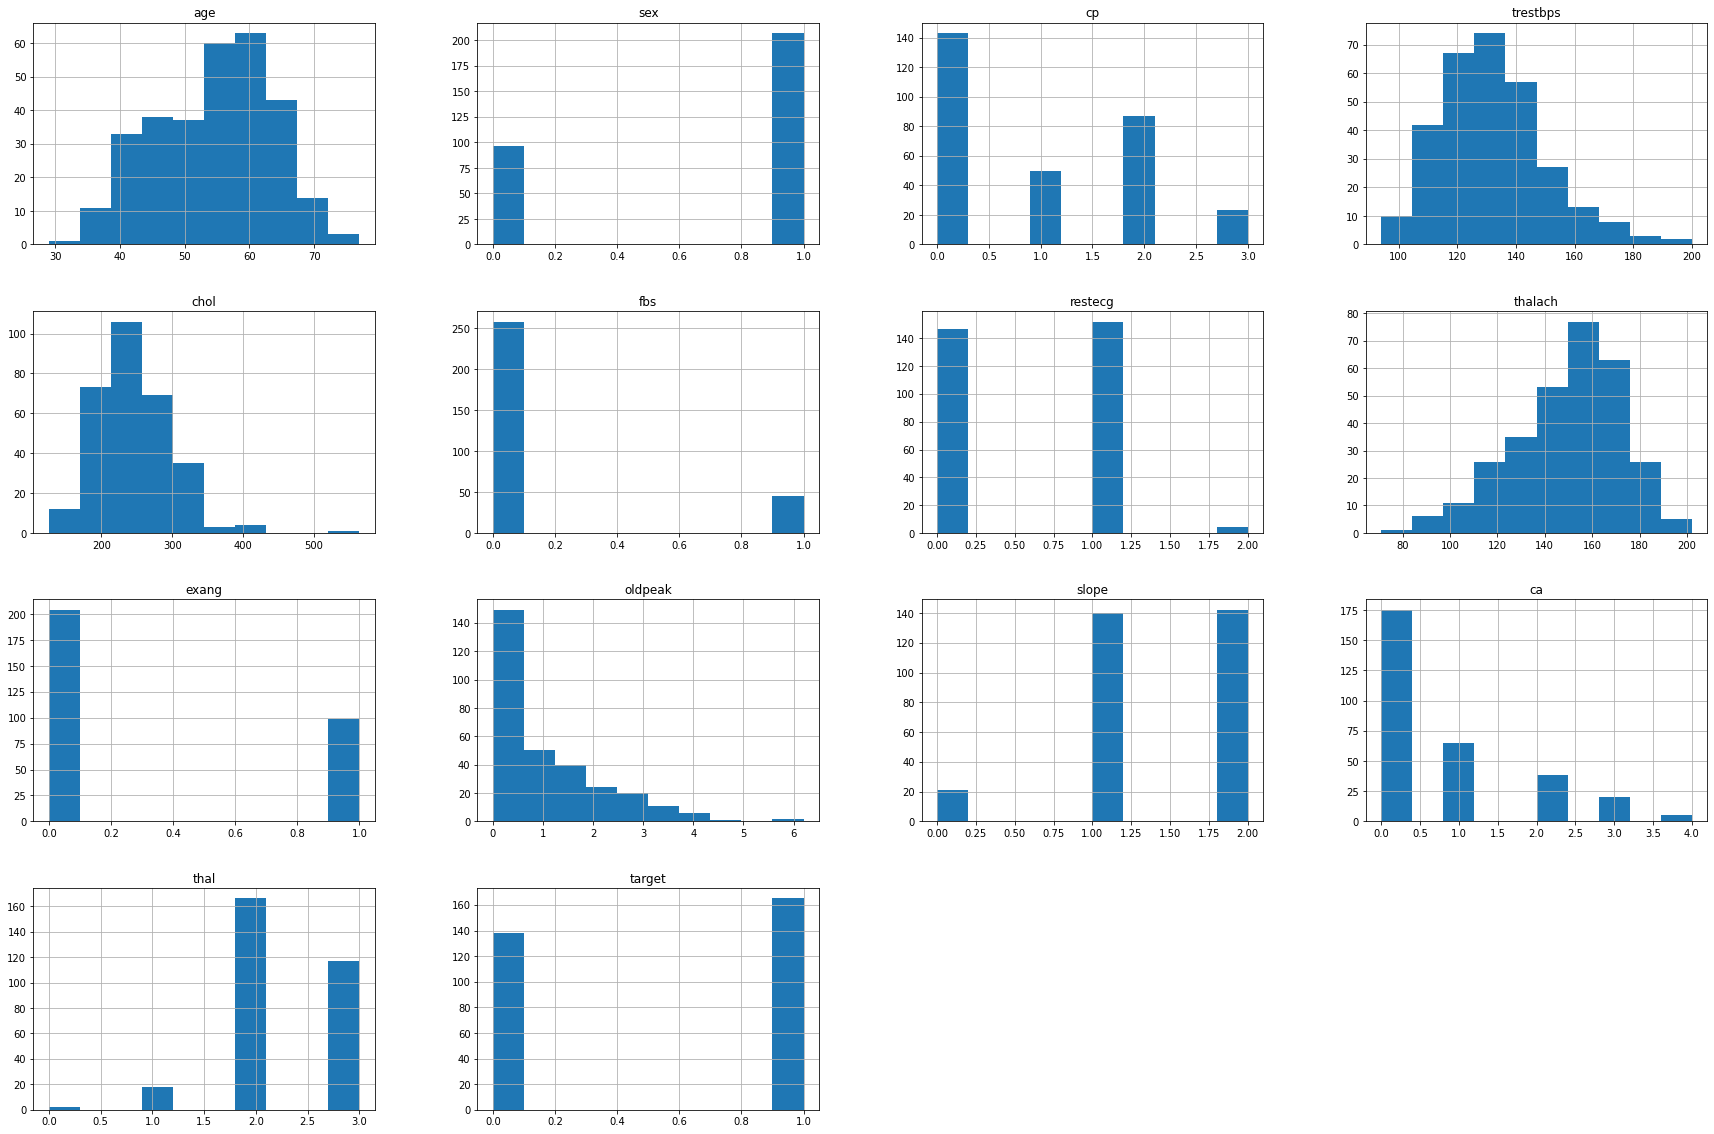

In [8]:
df.hist(figsize=(30,20))
plt.show()

I also wanted to get a feel for if there is any inbalance in the dependent variable. As seen below, the dataset is slightly inbalanced, but not the to the degree that I should be concerned that my models will not be effective.

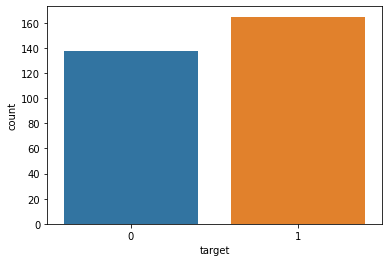

In [10]:
sns.countplot(x="target", data=df)
plt.show()

## Data cleaning
As the dataset was already in very good condition, the only additional cleaning I could think to do was to check for any correlated features and remove them from the model. I wrote some code to remove pairs of features which showed a high degree of correlation (>80%). I did this as my understanding is that highly correlated features are redundant in many classification algorithms, and are detrimental for some.

It turned out that none of the features were highly correlated, so this code is redundant, but I have kept it in for reference. I have also printed a matrix of correlation, which proves my code is correct!

In [15]:
corr_features =[]

for i , r in df.corr().iterrows():
    k=0
    for j in range(len(r)):
        if i!= r.index[k]:
            if r.values[k] >=0.5:
                corr_features.append([i, r.index[k], r.values[k]])
        k += 1

feat =[]
for i in corr_features:
    print(i[2])
    if i[2] >= 0.8:
        feat.append(i[0])
        feat.append(i[1])

df.drop(list(set(feat)), axis=1, inplace=True)

In [18]:

print(df.corr())

               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.098447 -0.068653  0.279351  0.213678  0.121308   
sex      -0.098447  1.000000 -0.049353 -0.056769 -0.197912  0.045032   
cp       -0.068653 -0.049353  1.000000  0.047608 -0.076904  0.094444   
trestbps  0.279351 -0.056769  0.047608  1.000000  0.123174  0.177531   
chol      0.213678 -0.197912 -0.076904  0.123174  1.000000  0.013294   
fbs       0.121308  0.045032  0.094444  0.177531  0.013294  1.000000   
restecg  -0.116211 -0.058196  0.044421 -0.114103 -0.151040 -0.084189   
thalach  -0.398522 -0.044020  0.295762 -0.046698 -0.009940 -0.008567   
exang     0.096801  0.141664 -0.394280  0.067616  0.067023  0.025665   
oldpeak   0.210013  0.096093 -0.149230  0.193216  0.053952  0.005747   
slope    -0.168814 -0.030711  0.119717 -0.121475 -0.004038 -0.059894   
ca        0.276326  0.118261 -0.181053  0.101389  0.070511  0.137979   
thal      0.068001  0.210041 -0.161736  0.062210  0.098803 -0.03

## Preparing the train/test set and dealing with categorical variables
Before dealing with all the categorical values, I split the dataset into a feature dataframe and a dependent variable dataframe, before splitting these into test/train sets on a 70/30 % split.

In [336]:
x = df.drop(['target'], axis=1)
y = df['target']

cat_features_string = ['sex','fbs','restecg','exang','slope','thal']
cat_features = [x.sex,x.fbs,x.restecg,x.exang,x.slope,x.thal]

for i in range(len(cat_features_string)):
    x_temp = pd.get_dummies(cat_features[i], prefix=cat_features_string[i])
    x = x.drop(cat_features_string[i],axis=1)
    x = x.join(x_temp)


In [337]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

Next I needed to deal with all the categorical features in the dataset. These were the sex, fbs, restecg, exang, slope and thal features. Note that the cp and ca features look categorical, but they are ordinal, as they have a natural ordering (increasing severity of chest pain and number of highlighted bllod vessels) so I have kept these are continious variables, albeit accross a small range.

 I used one-hot encoding to split each categorical feature into a series of new binary features which are more easily interpreted by many models. Some of the categories were alrady ordinal (have a antural ordering), but I have still one-hot encoded these as I am not aware of any negatives to this approach. I've printed the x_train dataframe to show what this has done.

## Data normalisation
The final bit of data manipulation to do was to scale the data, via the StandardScaler class. It is important to note that the scaling fit to the training set is the same scaling applied to the test set. This is to avoid the model learning anything about the test set before we let it attack it.

In [338]:
#collapse-output
scaler = StandardScaler()
scaler.fit(x_train)
scaler.transform(x_train)
scaler.transform(x_test)

array([[-0.58533247, -0.0089799 , -0.01274095, ..., -0.24494897,
         0.95389198, -0.83426614],
       [-1.15143869, -0.96084962,  0.10469735, ..., -0.24494897,
        -1.04833673,  1.19865825],
       [ 1.56587117,  0.94288982,  1.2790803 , ..., -0.24494897,
         0.95389198, -0.83426614],
       ...,
       [ 0.66010122, -0.96084962,  2.33602496, ..., -0.24494897,
        -1.04833673,  1.19865825],
       [ 1.45264993, -0.96084962,  1.74883348, ...,  4.0824829 ,
        -1.04833673, -0.83426614],
       [ 1.45264993, -0.96084962, -1.06968561, ..., -0.24494897,
         0.95389198, -0.83426614]])

## Model selection
The first thing to do was to decide which classification models I was going to experiment with. I have taken a selection of models which I am familiar with, or have heard of.

In [339]:
log_regression = linear_model.LogisticRegression()
n_bayes = naive_bayes.GaussianNB()
sgd = linear_model.SGDClassifier()
knn = neighbors.KNeighborsClassifier()
dec_tree = tree.DecisionTreeClassifier()
rand_forest = ensemble.RandomForestClassifier(n_jobs=-1)
svc = svm.SVC()

models = [log_regression, n_bayes, sgd, knn, dec_tree, rand_forest, svc]
model_names = ['Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Descent', 'K-Nearest-Neighbours', 'Decision Tree', 'Random Forest', 'Support Vector Classifier']


Next, I created a set of cross-validation sets via the sklearn KFold validator class. This allowed me to generate a preliminary scores for each model via cross-validation, without having to fully test each model (which would have taken an age!). 

I have chosen to evaluate my model with 4 scores; accuracy, F1 score, recall and precision. This is because accuracy is not always the best indicator of an effective classification model. The F1 score gives a balanced view of both precision and recall, but I have included recall and precision scores also, for completeness. 

As this is a medical classification model, we want to see a high recall rate in order to keep the false negative rates low, which can be dangerous in medical settings. If we can get a model that also has a high accuracy and F1 score, thereby reducing the number of false positives too, then even better!

In [340]:
print('Recall:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='recall')
    print(model_names[i] + ': ' + str(result.mean()) )

print('Precision:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='precision')
    print(model_names[i] + ': ' + str(result.mean()) )

print('F1:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='f1')
    print(model_names[i] + ': ' + str(result.mean()) )

print('Accuracy:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='accuracy')
    print(model_names[i] + ': ' + str(result.mean()) )


Recall:
Logistic Regression: 0.8800924013330027
Naive Bayes: 0.8129856463503079
Stochastic Gradient Descent: 0.4858560090702948
K-Nearest-Neighbours: 0.7308858226151458
Decision Tree: 0.7930175714010301
Random Forest: 0.8700867323987624
Support Vector Classifier: 0.9254385964912281
Precision:
Logistic Regression: 0.8315786638542056
Naive Bayes: 0.8493772309561782
Stochastic Gradient Descent: 0.7714285714285715
K-Nearest-Neighbours: 0.6587292093871041
Decision Tree: 0.7772203091763021
Random Forest: 0.8021119986456121
Support Vector Classifier: 0.6293854696028609
F1:
Logistic Regression: 0.8525817392164293
Naive Bayes: 0.8255877541591826
Stochastic Gradient Descent: 0.570452918009309
K-Nearest-Neighbours: 0.683342810808534
Decision Tree: 0.7841796462486118
Random Forest: 0.8277212205783634
Support Vector Classifier: 0.7402477037445304
Accuracy:
Logistic Regression: 0.8394777265745006
Naive Bayes: 0.8109062980030721
Stochastic Gradient Descent: 0.6125960061443932
K-Nearest-Neighbours: 0.

The results were interesting. If I ran the above code without changing anything then logistic regression came out on top, with an accuracy of 88 and an F1 score of 89.

If I removed the normalisation of the variables, I saw similar results.

If I removed the one-hot encoding but kept the normalisation the logistic regression classifier maintained its peformance, and was rivalled by naive bayes for both accuracy and F1 score.

If I removed normalisation and one hot encoding there was a slight hit to the peformance of the logistic regression model, and the naive bayes model came out on top with 82 accuracy and 84 F1.

As such, it was a toss up between naive bayes with no normalisaton or one-hot encoding, vs logistic regression with the above two steps enabled. I decided to stick with the code I had already written and make use of the logistic regression as this seemed to be the most consistent with some further repeated tests.

I believe the Naive Bayes classifier faltered with the one hot encoding enabled as I was using a gaussian Naive Bayes algorithm, which isn't best suited with alot of binary features. If I changed the Naive Bayes implementation to a Bernoulli Naive Bayes implementation then i received slightly better results, but still not as good as logisitic regression. I put this down to Bernoulli handling binary features well, but there are still plentyl of non binary features in the dataset.

Final decision: Logistic regression classifier.

## Hyperparameter tuning
I made the assumption that once tuned, the logistic regression classifier would still be the highest peforming model.

In this step, I chose the most prudent parameters which I thought would affect the peformance of the model.

In [341]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            }

Next, I used GridSearchCV to find the optimal set of my selected parameters; this turned out to be the 'l1' and 'liblinear'. The scoring I was comapring against was recall, as this is for medical classification I want as high a recall score as possible.

In [342]:
grid = GridSearchCV(log_regression, param_grid = parameters,n_jobs=-1, scoring='recall', verbose=2)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.best_params_)  

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.3s remaining:    0.1s
0.8833333333333334
{'penalty': 'l1', 'solver': 'liblinear'}
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


## Final model
Now that I have selected the optimal model and tuned its parameters, its a simple process to train and use the model on the dataset. I've printed the F1 and accuracy scores here for completeness.

Note that I have included an extra parameter 'n_jobs' which defines how many concurrent processes to run; -1 uses all available CPU cores so *shoud* speed it up!

In [343]:
log_regression = linear_model.LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000000, n_jobs=-1)
log_regression.fit(x_train,y_train)
predictions = log_regression.predict(x_test)
accuracy = metrics.accuracy_score(y_test,predictions)
f1 = metrics.f1_score(y_test,predictions)
recall = metrics.recall_score(y_test,predictions)
precision = metrics.precision_score(y_test,predictions)
print('Accuracy: '+str(accuracy))
print('F1 Score: '+str(f1))
print('Recall: '+str(recall))
print('Precision: '+str(precision))

Accuracy: 0.8131868131868132
F1 Score: 0.8210526315789474
Recall: 0.8666666666666667
Precision: 0.78


## Model evaluation
The model looks pretty good. 81% accuracy, F1 score of 82 and a nice high recall of 87, keeping the false negatives of heart disease down. 

I've visualised the confusion matrix and ROC plot below to see what the split of predictions is.

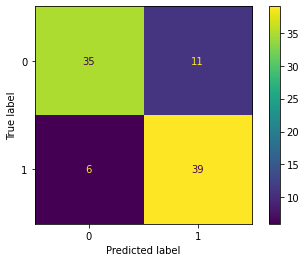

In [344]:
c_matrix = metrics.plot_confusion_matrix(log_regression, x_test,y_test)
plt.show()

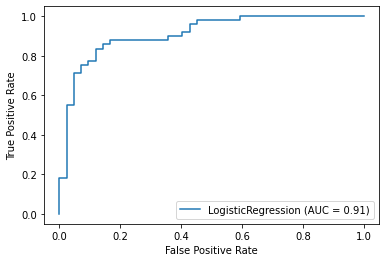

In [331]:
metrics.plot_roc_curve(log_regression, x_test,y_test)
plt.show()

On the surface, the model looks to be peforming strongly. The accuracy is high, the F1 score is strong, and the AUC is close to 1.

This being said, theres still roughly 13% of positive cases being mislabelled as negative cases. This could be down to the small sample size, or could indicate that the model needs further tweaking in order to favour recall over precision.

## Increasing Recall
In order to boost the recall value, I am going to experiment with the 'C' parameter for logistic regression. This is the inverse of regularisation strength, with smaller values normally leading to a greater recall. The default is 1, so let's lower it as see what happens.

Accuracy: 0.8241758241758241
F1 Score: 0.8367346938775511
Recall: 0.9111111111111111
Precision: 0.7735849056603774


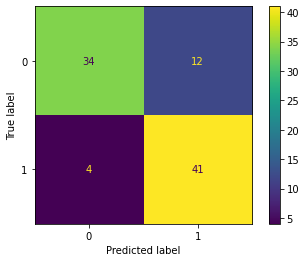

In [356]:
log_regression = linear_model.LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000000, n_jobs=-1, C=0.25)
log_regression.fit(x_train,y_train)
predictions = log_regression.predict(x_test)
accuracy = metrics.accuracy_score(y_test,predictions)
f1 = metrics.f1_score(y_test,predictions)
recall = metrics.recall_score(y_test,predictions)
precision = metrics.precision_score(y_test,predictions)
print('Accuracy: '+str(accuracy))
print('F1 Score: '+str(f1))
print('Recall: '+str(recall))
print('Precision: '+str(precision))

c_matrix = metrics.plot_confusion_matrix(log_regression, x_test,y_test)
plt.show()

With the reduced C value I can get the recall to 91 and the false negative rate to under 10% of true negatives. That is pretty good for a normal classification model, but this certainly wouldn't be up to scratch for a true medical model!

To improve the model further I think that I would need to do some in depth feature engineering. This would require a level of medical domain knowledge which I do not posess, so for now I am going to accept my model as adequate.




## Feature analysis
Finally, I want to take a look at which features had the most signficance on the model. The simplest thing to do here is to take a look at the coefficients asscoiated with each feature. The higher the coefficient, the higher its influence on the model.

<BarContainer object of 23 artists>

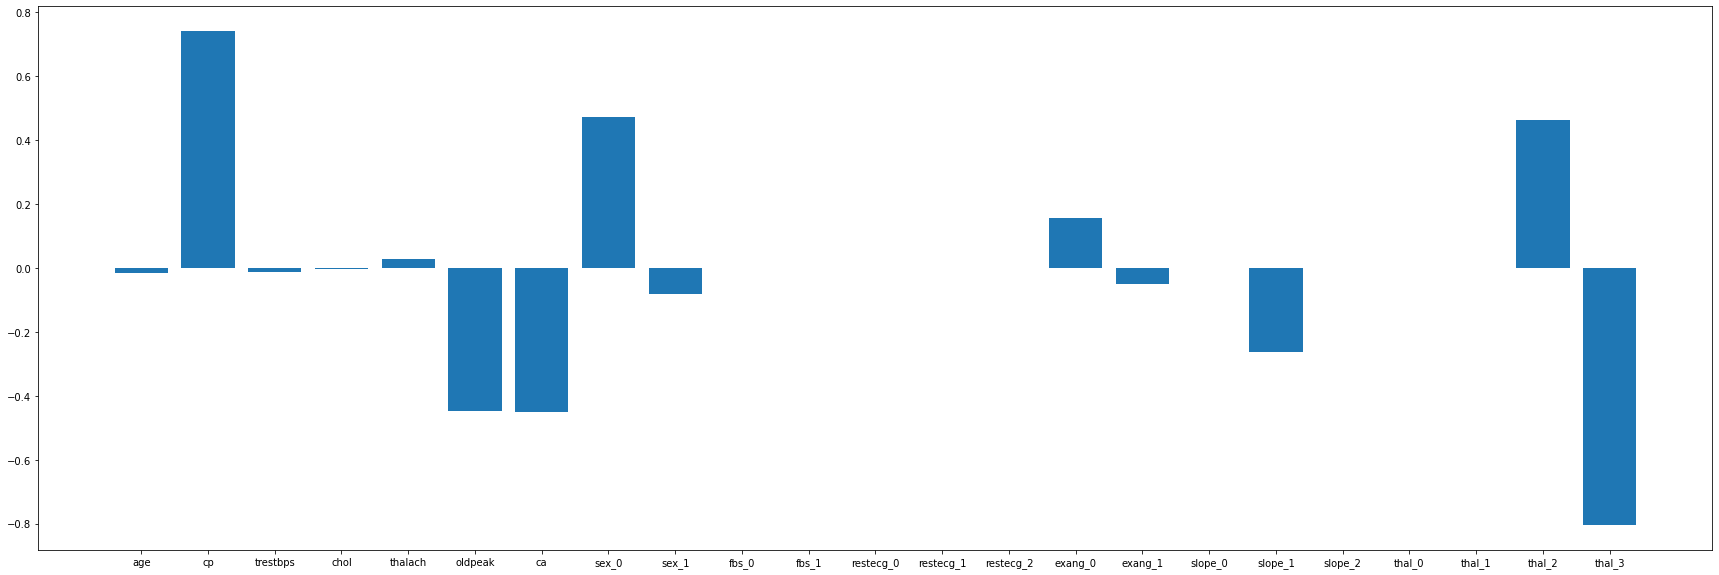

In [359]:
coefs = log_regression.coef_[0]
features = x_train.columns.tolist()

fig = plt.figure(figsize=[30,10])
plt.bar(features, coefs)


This led to some interesting insight. Firsly, age did not play a big part in the model, which may be of surprise. Chest pain severity was a big factor, as expected, and maximum heartrate and number of major blood vessels visible under fluoroscopy were strongly weighted against heart disease, which does make sense.

Being male was a strong factor in favour of heart disease, and interestingly, was a stronger weight than the weight of being a woman factoring into not having heart disease.

Finally, having a normal condition of thalassemia was a very strong factor in favour of no heart disease.

These results seem reasonable, however I am not a doctor, nor do I have any background in medicine, so my interpretation of these results is somewhat limitted. That is why data science is so interesting, as if I was truly tasked with this problem then I would have to become clued up on the subject matter in order to analyse in depth.





## Conclusion
In this notebook I have experimented with classification models, and found an optimal model to use on the medical dataset. The process included data manipulation and cleaning, correlated feature removal, feature scaling, cross-validation to select the best type of model, hyperparameter tuning, utilisation of the tuned model, evaluation alongside visualisation and finally, an analysis of feature significance.

Final accuracy and F1 scores sat at roughly 0.83. I think this is close to the maximal peformance I can get out of this dataset without doing some more complex feature engineering, increasing the sample size, or using a more in depth feature set.

I welcome any feedback, comments or suggestions for improvement!